# Notebook 3: Dealing with Multicolinearity

Before trying to change the model, we want to reduce the data set we are using. A common heuristic recommends 10 data points per feature for regression. Additionaly, we have similar and thus highly correlated features. We decided to reduce the number of features from 120 to 1/5/10/20/30/40/50/75/100/140 and 121 (for comparison with the hand picked reduced data set). 

We tried two different criteria for selecting remaining features: the total amount of correlation and the Variance inflation factor (VIF).

In [36]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os
import tqdm
import glob
import pandas as pd
import sklearn
from src import corr_utils as corr_utils
from src import ana_utils as ana_utils
import collections
import scipy.stats

#import tueplots
#from tueplots import bundles
#from tueplots import figsizes

#np.set_printoptions(suppress=True)
from sklearn.linear_model import LinearRegression

np.random.seed(7)

Import datasets that were preprocessed in Notebook 1

In [11]:
wb_data = pd.read_csv("data/wb_data.csv", index_col="Country Name")
wb_data_short = pd.read_csv("data/wb_data_short.csv", index_col="Country Name")
whr_data = pd.read_csv("data/whr_data.csv", index_col="Country name")

### Sighting Correlation 

First, we wanted to get a first impression of the amount of multicolinearity present in the data. Therefore, we created a correlation matrix.

Text(0.5, 1.0, 'Correlation Matrix')

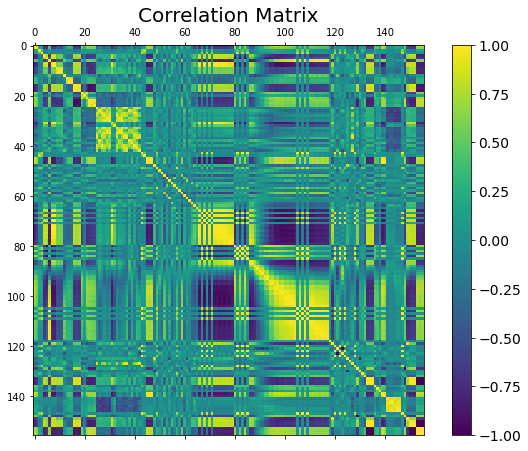

In [12]:
indicator_corr = wb_data.corr(method="pearson")

f = plt.figure(figsize=(10, 7))
plt.matshow(indicator_corr, fignum=f.number)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=20)

### Pearson's r indicator removal

Since we have multiple cluster of correlated features, we wondered what these clusters are. We build a function that returns a dict of indicators and their total correlation measured by Pearson's r (sum of absolute correlation coefficients across all the other indicators). 

In [13]:
corr_dict = corr_utils.corr_counter(indicator_corr)
corr_dict_sorted = sorted(corr_dict.items(), key=lambda x: x[1], reverse=True) 
#corr_dict_sorted

Since we do not want to remove a complete cluster, which could happen if we just threw out a big chunk of the correlated data, we decided on an iterative procedure that removes indicators one-by-one until the data is reduced to the desired number of indicators. We choose 10, 20, 30, 50 and 70. Originally, only 10, 20, 30.

In [14]:
columns_by_corr = corr_utils.pearsons_reduction(wb_data, 1)

In [15]:
columns_by_corr.reverse()
wb_data_pear_sorted = wb_data[columns_by_corr]

In [16]:
least_squares = sklearn.linear_model.LinearRegression()
test_size = 30
num_indicator_list = [1, 5, 10, 15, 20, 25, 30, 35, 40, 50, 75, 100, 121, 140, 156]
ceval_kwargs = {"reg_model" : least_squares, "n" : 1000, "gt" : whr_data, "test_size" : test_size, "scaling" : "normalize", "calc_adj_r_squared" : True}


pearson_mean_loss_list, pearson_mean_train_loss_list, _ = corr_utils.multi_ceval(num_indicator_list, wb_data_pear_sorted, True, **ceval_kwargs)


Number of indicators: 1
Mean loss: 1.271701994052477
Mean train loss: 1.2306822229746375
STD of the Loss: 0.25869803507225747
Adjusted R-Squared:  0.0007428882099304052
The average size of the coefficients: 1.5462 

Number of indicators: 5
Mean loss: 4.631787543991621
Mean train loss: 1.0228725883945289
STD of the Loss: 10.125329593498723
Adjusted R-Squared:  0.13901429359173045
The average size of the coefficients: 3.07436 

Number of indicators: 10
Mean loss: 4.818218041413849
Mean train loss: 0.9011532820504963
STD of the Loss: 9.708213072721938
Adjusted R-Squared:  0.2080643352017147
The average size of the coefficients: 5.34512 

Number of indicators: 15
Mean loss: 3.460910423723586
Mean train loss: 0.6931075125467369
STD of the Loss: 6.597326131237168
Adjusted R-Squared:  0.3607974484354883
The average size of the coefficients: 3.18954 

Number of indicators: 20
Mean loss: 3.062555604833707
Mean train loss: 0.6038810934310446
STD of the Loss: 5.772025445006425
Adjusted R-Squared:

Since high correlations are especially undesired, we created a variation of the Pearson Reduction that squares the correlation before summing it up.

In [17]:
columns_by_corr_squared = corr_utils.pearsons_reduction(wb_data, 1, sum_of_squares=True)

In [18]:
columns_by_corr_squared.reverse()
wb_data_pear_square_sorted = wb_data[columns_by_corr_squared]

In [19]:
least_squares = sklearn.linear_model.LinearRegression()
test_size = 30
num_indicator_list = [1, 5, 10, 15, 20, 25, 30, 35, 40, 50, 75, 100, 121, 140, 156]
ceval_kwargs = {"reg_model" : least_squares, "n" : 1000, "gt" : whr_data, "test_size" : test_size, "scaling" : "normalize", "calc_adj_r_squared" : True}


pearson_square_mean_loss_list, pearson_square_mean_train_loss_list, _ = corr_utils.multi_ceval(num_indicator_list, wb_data_pear_square_sorted, True, **ceval_kwargs)


Number of indicators: 1
Mean loss: 1.2767939183007095
Mean train loss: 1.2295071896196454
STD of the Loss: 0.26059972341844306
Adjusted R-Squared:  0.0011310055564953477
The average size of the coefficients: 1.5547 

Number of indicators: 5
Mean loss: 5.27125397104203
Mean train loss: 1.018499441070006
STD of the Loss: 11.434222898772381
Adjusted R-Squared:  0.1401918692546379
The average size of the coefficients: 3.1836599999999997 

Number of indicators: 10
Mean loss: 4.262576243287324
Mean train loss: 0.9007837005248451
STD of the Loss: 8.790865563756448
Adjusted R-Squared:  0.2057287842995222
The average size of the coefficients: 5.3307199999999995 

Number of indicators: 15
Mean loss: 3.0201258012651717
Mean train loss: 0.6951419250067938
STD of the Loss: 5.87317359345031
Adjusted R-Squared:  0.3573722974017462
The average size of the coefficients: 3.1532600000000004 

Number of indicators: 20
Mean loss: 2.9228582486191144
Mean train loss: 0.6039913370146357
STD of the Loss: 5.155

### VIF indicator removal

Our second approach instead uses the variance inflation factor to, again, iteratively remove indicators from the data set.

In [20]:
columns_by_vif = corr_utils.vif_reduction(wb_data, 1)

In [21]:
columns_by_vif.reverse()
wb_data_vif_sorted = wb_data[columns_by_vif]

In [22]:
least_squares = sklearn.linear_model.LinearRegression()
test_size = 30
num_indicator_list = [1, 5, 10, 15, 20, 25, 30, 35, 40, 50, 75, 100, 121, 140, 156]
ceval_kwargs = {"reg_model" : least_squares, "n" : 1000, "gt" : whr_data, "test_size" : test_size, "scaling" : "normalize", "calc_adj_r_squared" : True}


vif_mean_loss_list, vif_mean_train_loss_list, _ = corr_utils.multi_ceval(num_indicator_list, wb_data_vif_sorted, True, **ceval_kwargs)


Number of indicators: 1
Mean loss: 5.673283368364728
Mean train loss: 1.1761201563933628
STD of the Loss: 10.889463304900348
Adjusted R-Squared:  0.04481549916272403
The average size of the coefficients: 7.4041 

Number of indicators: 5
Mean loss: 5.103925322755627
Mean train loss: 1.0861215025402913
STD of the Loss: 10.947051937197259
Adjusted R-Squared:  0.08501245727847964
The average size of the coefficients: 7.40642 

Number of indicators: 10
Mean loss: 4.173469253082471
Mean train loss: 0.7702181921473993
STD of the Loss: 8.762910958572853
Adjusted R-Squared:  0.32002870529769256
The average size of the coefficients: 4.4521999999999995 

Number of indicators: 15
Mean loss: 2.8277336424731714
Mean train loss: 0.5795642882215809
STD of the Loss: 5.5166947396345245
Adjusted R-Squared:  0.4657237029842914
The average size of the coefficients: 2.759133333333333 

Number of indicators: 20
Mean loss: 1.498024999842325
Mean train loss: 0.4014372028415905
STD of the Loss: 2.69967981725706

### Baseline Reduction

To have a baseline comparison for our reduced data sets, we create 20 datasets each for different sizes and do 50-fold cross validation.
We then average the errors across the 50*20 models. 

In [23]:

rand_loss_list, rand_train_loss_list, rand_std_list = corr_utils.ind_removal_sim([1, 5, 10, 15, 20, 25, 30, 35, 40, 50, 75, 100, 121, 140, 156], 20, sklearn.linear_model.LinearRegression(), 50, wb_data, whr_data)

Number of indicators 1
Avg. Loss 0.9475594209801613
Avg. Train loss 0.9080080710113572
Loss STD 0.25888927372633924
Avg. Total Coef. Size 15.77082 

Number of indicators 5
Avg. Loss 0.6457800629532926
Avg. Train loss 0.56272379157999
Loss STD 0.14219659938355886
Avg. Total Coef. Size 54.645495 

Number of indicators 10
Avg. Loss 0.561015274407224
Avg. Train loss 0.4287961076274488
Loss STD 0.08636250317823274
Avg. Total Coef. Size 89.02521000000002 

Number of indicators 15
Avg. Loss 0.5700701506346387
Avg. Train loss 0.36179997796250296
Loss STD 0.1219924360258232
Avg. Total Coef. Size 187.99547 

Number of indicators 20
Avg. Loss 0.5518708299832623
Avg. Train loss 0.30477670923187533
Loss STD 0.1490378145046327
Avg. Total Coef. Size 336.93797000000006 

Number of indicators 25
Avg. Loss 0.5310431534703193
Avg. Train loss 0.2465093571994827
Loss STD 0.13216749102011519
Avg. Total Coef. Size 349.90585999999996 

Number of indicators 30
Avg. Loss 0.5663561494884694
Avg. Train loss 0.213

Surprisingly, removing indicators randomly outperforms Pearson's R Reduction and delivers results very close to VIF reduction when using Linear Regression. 

In [37]:
#from matplotlib import rcParams

# couldnt use the best package ever :( 
# weird errors
#plt.rcParams.update(bundles.neurips2021())
#plt.rcParams.update(figsizes.neurips2021(nrows=1, ncols=3, constrained_layout=True, height_to_width_ratio=1))
#plt.size([7,5])

plt.plot(num_indicator_list, vif_mean_loss_list,"-s", label = "VIF reduction")
plt.plot(num_indicator_list, pearson_mean_loss_list, "-p", label = "Pearson's R reduction")
plt.plot(num_indicator_list, pearson_square_mean_loss_list, "-o", label = "Pearson's R square reduction")
plt.plot(num_indicator_list, rand_loss_list, "-*", label = "Random Reduction")
plt.plot(121, 5.1,'rx', label="Reduction by hand (WB_short)") 
plt.legend()
#plt.title("Least Squares Test Losses for Different Data Reduction Methods")
#plt.xlim([0,60])
#plt.ylim([0,6])
plt.xlabel("Number of Remaining Indicators")
plt.ylabel("Cross-validated MSE")
#plt.errorbar(loss_list, rand_std_list)
#plt.savefig("reduction_plot.pdf", format="pdf")

Text(0, 0.5, 'Cross-validated MSE')

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\samue\\.matplotlib\\tex.cache\\9f8099ca338d571add13d7c5b17c0358.tex'

<Figure size 432x288 with 1 Axes>

Text(0, 0.5, 'Train MSE')

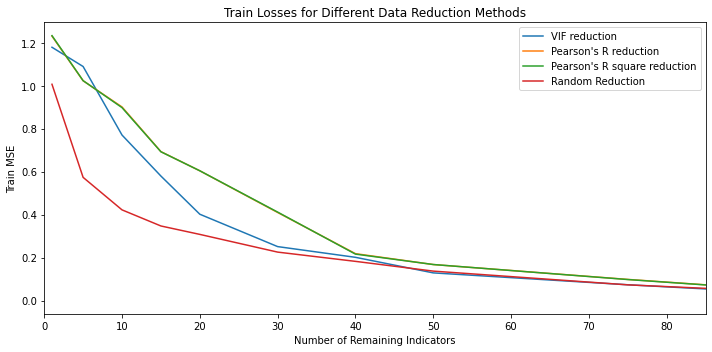

In [ ]:
plt.figure(figsize=(10,5))

plt.errorbar(num_indicator_list, vif_mean_train_loss_list, label = "VIF reduction", barsabove=True)
plt.errorbar(num_indicator_list, pearson_mean_train_loss_list, label = "Pearson's R reduction")
plt.errorbar(num_indicator_list, pearson_square_mean_train_loss_list, label = "Pearson's R square reduction")
plt.errorbar(num_indicator_list, rand_train_loss_list, label = "Random Reduction")
plt.legend()
plt.title("Train Losses for Different Data Reduction Methods")
plt.xlim([0,85])
plt.xlabel("Number of Remaining Indicators")
plt.ylabel("Train MSE")
#plt.ylim([0,5])
#plt.errorbar(loss_list, rand_std_list)

### Export reduced datasets
Lastly, we export our reduced datasets so we can test them on other models later on.

In [ ]:
wb_data_pear_sorted.to_csv("data/wb_data_pear_sorted.csv", index=False)
wb_data_pear_square_sorted.to_csv("data/wb_data_pear_square_sorted.csv", index=False)
wb_data_vif_sorted.to_csv("data/wb_data_vif_sorted.csv", index=False)